Proyecto 1 BI
Tema: Datos Peliculas

# Librerias

In [1]:
import string

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

import pickle

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns

# Set Up Inicial

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
# Descargando las stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Función para tokenizar los tweets
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

# Cargar Info

In [6]:
tweets_df = pd.read_csv('/content/MovieReviews.csv', sep = ',')

In [7]:
tweets_df.shape

(5000, 3)

In [8]:
tweets_df.sample(5)

,Unnamed: 0,review_es,sentimiento
2449,2449,"David Cronenberg, al igual que el colega David Lynch, es un gusto adquirido. Un director que juega con temas como la realidad, la perversión, el sexo, la locura y la muerte, está obligado a obtener las mejoras más extremas de las audiencias. Probó esto con las películas como la mosca, el almuerzo desnudo, el choque y Extentez (Capital X, Capital Z) y más recientemente, Spider. Es mejor ver a Existenz con una mente clara. Trate de no leer demasiado sobre la trama, o se arruinará para usted. Lo que puedo decirte es que Cronenberg te lleva a un viaje hacia el mundo de los videojuegos que actúa como una metáfora para cualquier tipo de comportamiento escapista. Living Out Fantasies es algo que la gente siempre sueña, pero ¿a qué distancia puede entrar en él, antes de que la realidad se vuelva borrosa y la fantasía se hace cargo y se convierte en una pesadilla? Esos son los temas tocados en existenz, una exploración de identidad, la psique humana, los cuerpos físicos que son invadidos por la enfermedad y lo más importante, la realidad misma. La historia y la dirección son excelentes. Cronenberg conoce a su comercio muy bien y tiene éxito a la vida un mundo artificial, evitando los escollos habituales y los clichés vinculados a historias como esta. La película muestra algunas cosas bastante repugnantes, pero es una clave inusualmente baja en el departamento de Gore en comparación con Cronenbergs Otro trabajo. Los efectos de choque que juega nunca están por encima y la progresión de la trama es muy inteligente y creativa. No es la película más intelectual de todos, pero te dejará pensar en ello, preguntándose y bastante confundido. La actuación también obtiene dos pulgares arriba. Tanto los protagonistas, Jennifer Jason Leigh y Jude Dery, juegan sus partes perfectamente e inteligentemente retratan los cambios e identidades cambiantes de su personaje. El diálogo puede parecer un poco estancado y clínico a veces, pero eso es parte del efecto que estaba iba a crear, crear una atmósfera no afectada y alienígena que lo pone en exceso. Apoyando a los actores como Ian Holm, Don McKellar y un Willem, especialmente espeluznante, Dafoe, levanta la película aún más alta con sus actuaciones inquietantemente familiares. Esta película lleva a los demás acostumbrarse, pero si puedes apreciar el tono oscuro, las imágenes de la sangre de la sangre y la historia de la deformación existencial. , te va a encantar.",positivo
3249,3249,"(Avast, leve spoilers por delante) Tengo esta cinta de mi biblioteca local, que mantiene una copia por razones obvias. Una vez fui a la ciudad de Matewan, Virginia Occidental, y en un pequeño museo, vi el horario para el teatro de la ciudad. CITRA MAYO DE 1954. Las películas cambiarían en el teatro cada día. Como no habría televisión por otra década aproximadamente en esas partes, este fue gran parte del entretenimiento disponible en la ciudad. ""El RAID"" parece haberse hecho para ciudades como Matewan en la década de 1950. Aunque no se cotizaba en la lista de ese mes, estoy seguro de que había un poco de lunes o martes por la noche para una audiencia que probablemente no era demasiado exigente. La incursión histórica, atrevida y notablemente exitosa, no parecía haber sido muy bien investigada, por lo que la película está llena de adornos de Hollywood, incluyendo un cañón suelto jugado por Lee Marvin. Marvin utiliza la oportunidad de practicar la libertad de libertad. Y St. Albans parece haber tenido más soldados de Yankee que vienen y pasan por la ciudad que Washington D.C.. ¿Qué realmente me hizo risificar fue cuando los asaltantes cambian a sus uniformes confederados? Solo en pinturas de guerra civil pegajosa, los uniformes rebeldes se ven tan prístinos. Cuando el hijo de Anne Bancroft atrapa a Van Heflin en su uniforme justo antes de la redada, esperaba que el niño creyera que era Halloween. Y luego está a sí misma Anne Bancroft. Mientras observaba la película, realmente mir

In [9]:
tweets_df['sentimiento'].value_counts(dropna = False, normalize = True)

positivo    0.5
negativo    0.5
Name: sentimiento, dtype: float64

# Filtrando Tuits No Etiquetados

In [10]:
tweets_labeled_df = tweets_df.loc[tweets_df['sentimiento'].notnull()]

In [11]:
# Tweets a ser usados para entrenar y evaluar el modelo
tweets_labeled_df.shape

(5000, 3)

In [12]:
# Tweets descartados debido a que no se encuentran etiquetados
tweets_df.loc[tweets_df['sentimiento'].isnull()].shape

(0, 3)

In [13]:
tweets_df['sentimiento'].value_counts(dropna = False, normalize = True)

positivo    0.5
negativo    0.5
Name: sentimiento, dtype: float64

#Conjuntos de Prueba

In [50]:
tweets_df['sentimiento'] = tweets_df['sentimiento'].map({'positivo': 1, 'negativo': 0})

In [17]:
tweets_df['sentimiento'].unique()

array([1, 0])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(tweets_df['review_es'], tweets_df['sentimiento'], test_size = 0.2, stratify = tweets_df['sentimiento'], random_state = 1)

In [19]:
X_train.shape

(4000,)

In [20]:
pd.Series(y_train).value_counts(normalize = True)

0    0.5
1    0.5
Name: sentimiento, dtype: float64

In [21]:
X_test.shape

(1000,)

In [22]:
pd.Series(y_test).value_counts(normalize = True)

0    0.5
1    0.5
Name: sentimiento, dtype: float64

# Vectorización de Tuits

In [23]:
stop_words=list(stop_words)

In [24]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True)

In [25]:
X_bow = bow.fit_transform(X_train)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [26]:
len(bow.vocabulary_)

58404

In [27]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True)

In [28]:
X_tfidf = tfidf.fit_transform(X_train)

In [29]:
len(tfidf.vocabulary_)

58404

# Entreno con Bow

In [30]:
bow_model = RandomForestClassifier(random_state = 2)

In [31]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<Axes: >

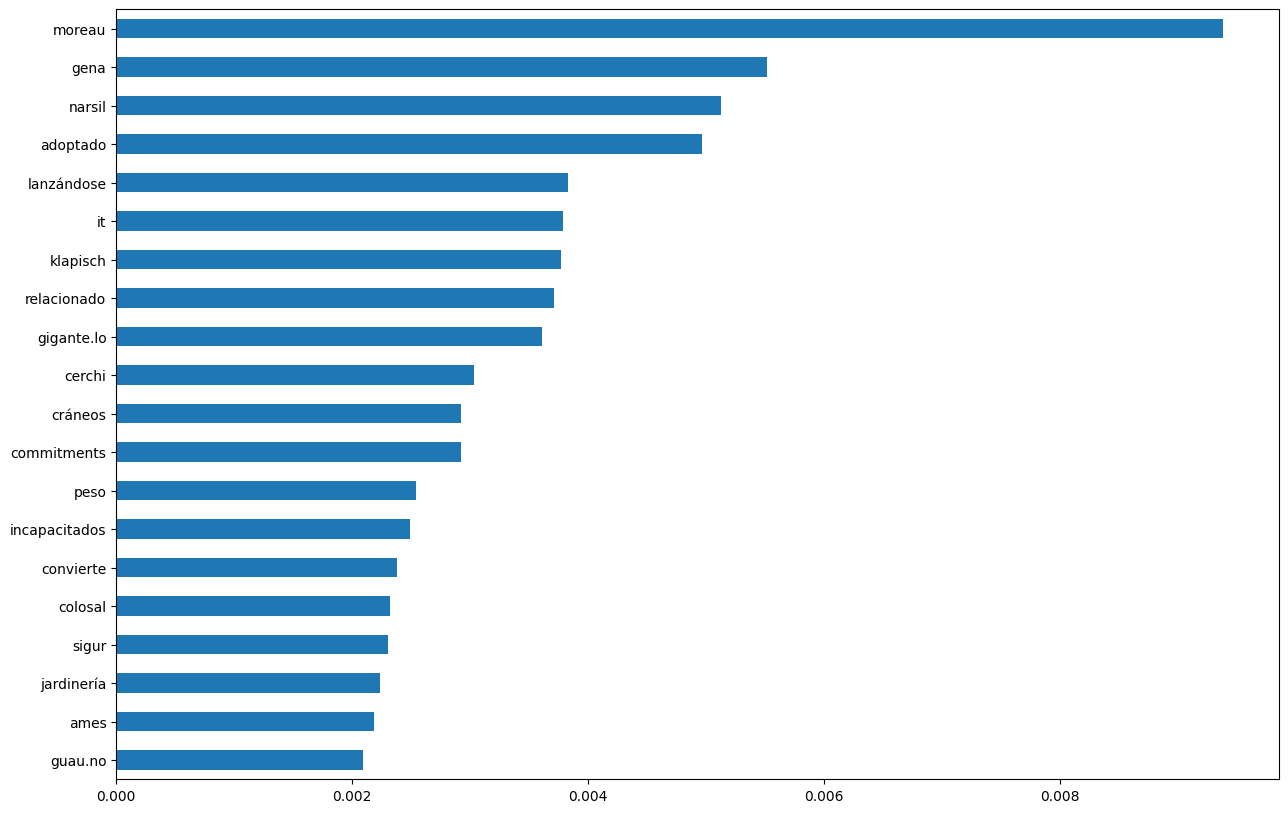

In [32]:
# La 'feature importance' en modelos basados en árboles de decisión indican cuales son las características más importantes al momento de tomar una decisión
pd.Series(bow_model.feature_importances_, index = bow.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [33]:
bow_estimators = bow_model.estimators_
print('Number of trees:', len(bow_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 185.1


In [34]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test))

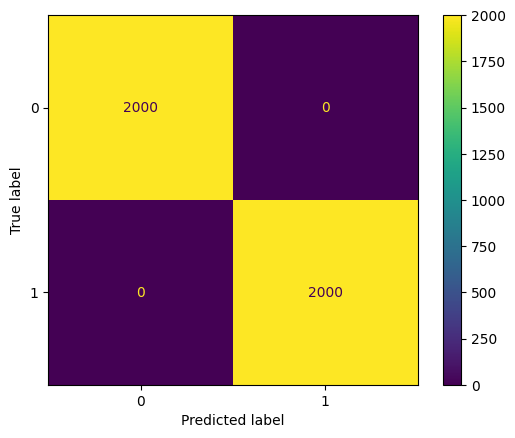

In [35]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

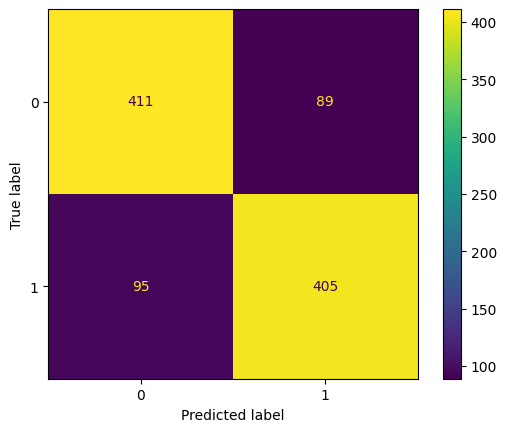

In [36]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [37]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_bow_predict, pos_label = 1))
    print('Recall:', recall_score(y_train, y_train_bow_predict, pos_label = 1))
    print('F1:', f1_score(y_train, y_train_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_bow_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_bow_predict, average = None))
    print('F1:', f1_score(y_train, y_train_bow_predict, average = None))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [38]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_bow_predict, pos_label = 1))
    print('Recall:', recall_score(y_test, y_test_bow_predict, pos_label = 1))
    print('F1:', f1_score(y_test, y_test_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
    print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: 0.819838056680162
Recall: 0.81
F1: 0.8148893360160966


# Evaluando e utilizando TF-IDF

In [39]:
tfidf_model = RandomForestClassifier(random_state = 3)

In [40]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

<Axes: >

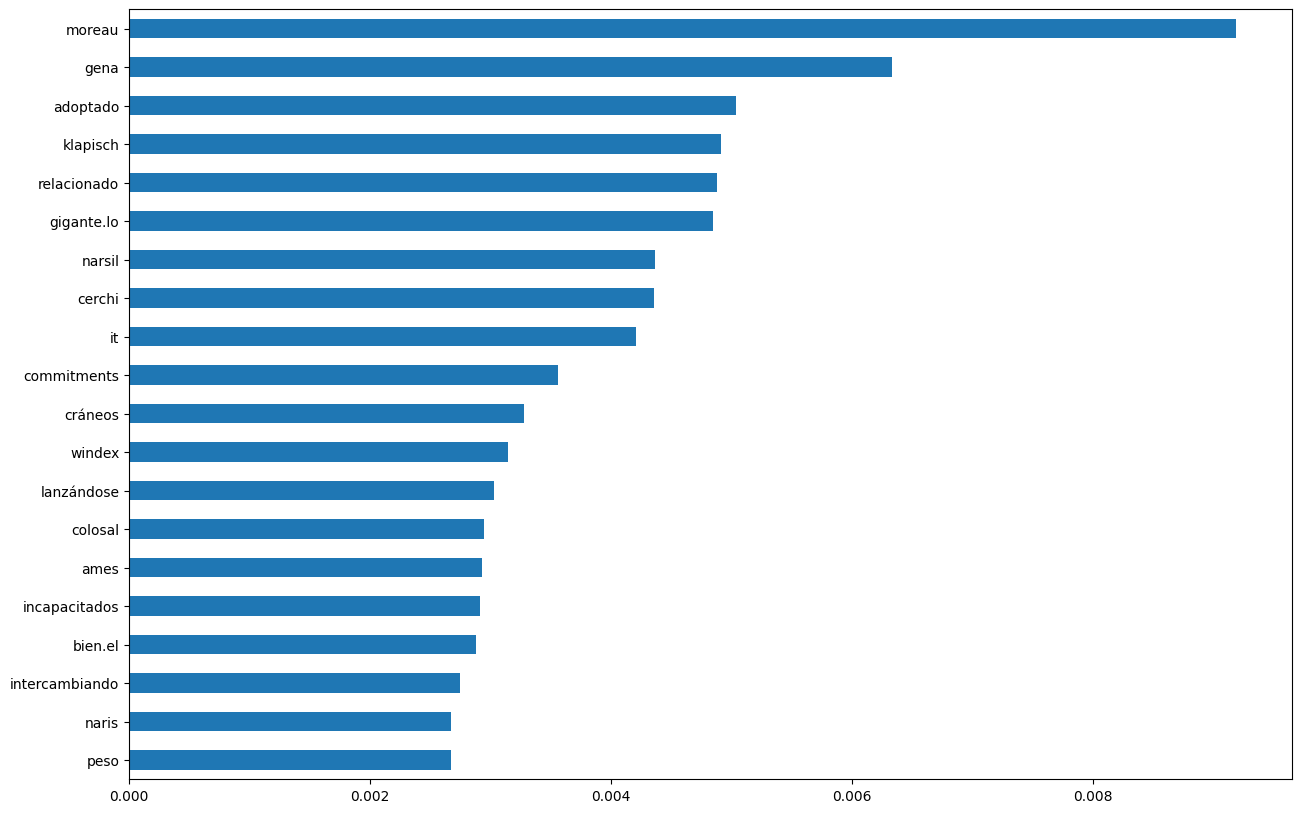

In [41]:
pd.Series(tfidf_model.feature_importances_, index = tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [42]:
tfidf_estimators = tfidf_model.estimators_
print('Number of trees:', len(tfidf_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 162.79


In [43]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test))

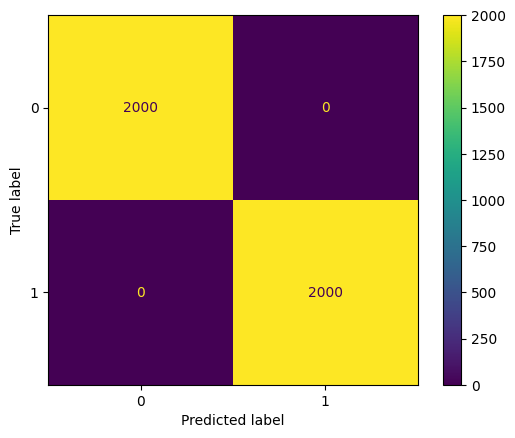

In [44]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

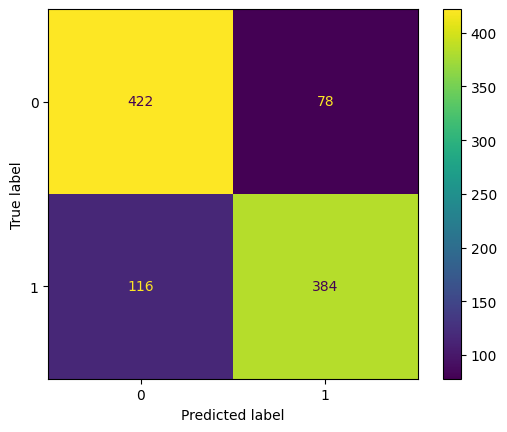

In [45]:
ConfusionMatrixDisplay.from_predictions(y_test,y_test_tfidf_predict)

In [51]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_tfidf_predict, pos_label = 1))
    print('Recall:', recall_score(y_train, y_train_tfidf_predict, pos_label = 1))
    print('F1:', f1_score(y_train, y_train_tfidf_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_tfidf_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_tfidf_predict, average = None))
    print('F1:', f1_score(y_train, y_train_tfidf_predict, average = None))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [52]:
if len(tfidf_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_tfidf_predict, pos_label = 1))
    print('Recall:', recall_score(y_test, y_test_tfidf_predict, pos_label = 1))
    print('F1:', f1_score(y_test, y_test_tfidf_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
    print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: 0.8311688311688312
Recall: 0.768
F1: 0.7983367983367984


# Limpieza de Datos y decisión de tipo de vectorización (Bag of Words)

Mejores resultados Bow entonces trabajaremos con ese. Pero sin incluir los tokens de aparición de 1 solo caso.

In [53]:
stop_words=list(stop_words)

In [54]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True, min_df=2)

In [55]:
X_bow = bow.fit_transform(X_train)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [56]:
len(bow.vocabulary_)

24988

In [57]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True)

In [58]:
X_tfidf = tfidf.fit_transform(X_train)

In [59]:
len(tfidf.vocabulary_)

58404

# Análisis del error


In [59]:
error_df = pd.concat([
    pd.concat([X_test, y_test], axis = 1).reset_index(),
    pd.Series(y_test_bow_predict)
], axis = 1).rename(columns = { 'sentimiento': 'actual', 0: 'predicted' })

error_df.drop('index', inplace = True, axis = 1)

In [60]:
error_df.loc[error_df['actual'] != error_df['predicted']].shape

(184, 3)

In [61]:
error_df.loc[error_df['actual'] != error_df['predicted']].sample(10)

,review_es,actual,predicted
887,"Confieso: Emma, ​​en mi opinión, es la mejor novela más grande jamás escrita. Está tan cerca de la perfección, ya que puede ser cualquier creación mortal. Jane Austen llega al pináculo de su arte aquí. Desafortunadamente, esto es, en el mejor de los casos, una versión de Gwynett Paltrow es inevitable, esa versión es mucho más fiel al espíritu ingenioso del libro y mucho más agradable para ver. Hay algunos buenos elementos aquí: Kate Berkinsale (Habiendo jugado previamente la flora Poste en Fría Comfort Farm, claramente Emma's Smarter Spiritual gemelo) es una emma maravillosa. Raymond Coulthard hace una decoración apropiada Frank Churchill. La producción es guapo, pero los interiores son demasiado oscuros. Sin embargo, hay varios problemas importantes. El primero es Mark Strong, en primer lugar, no se ve bien para el Sr. Knightley. Esto es quizás porque juega el papel como un párroco victoriano censurable. Está muy fuera de la melodía. El segundo problema es de la longitud. En pocas palabras, la película es demasiado corta: para obtener el tipo de sensación correcto, tendría que ser el doble de largo. Finalmente, y lo más significativamente, existe la calidad de la adaptación. Austen es el sueño de un adaptador, todo el diálogo ya está allí. Solo necesita ser podado y arreglado adecuadamente. Andrew Davies parece pensar de otra manera. Primero, esta es una película bastante sombría, y lo último que debe ser Emma es sombrío. Más significativamente, Davies ha visto apto para reescribir el final como algún tipo de fiesta bucólica. ¿De qué planeta, o trabajo menor de Thomas Hardy, es esto de? Está completamente fuera del estilo y el espíritu de la novela. Y creo que es enormemente presuntuoso para tratar de realizar mejoras en: una preservación de la versión de Paltrow, o observar a Kate en Fría Comfort Farm.",0,1
581,"No podría relacionarme con esta película.No se convirtió en comprometerme intelectualmente, emocional o estéticamente.El diálogo fue muy denso y sin resolver.No podía conectarme y, por lo tanto, me preocupo por ninguno de los personajes y me resulta difícil encontrar mucho que sea positivo para decirlo. He leído que para entenderlo adecuadamente, se necesita familiarizarse con algunos de los másASPECTOS oscuros de la teología católica.Admito que, como ateo, probablemente estoy familiarizado con muchos de los detalles más finos del catolicismo, pero también he visto muchas películas que tratan los problemas religiosos que me han tocado porque sus temas siguen siendo universales para la condición humana y DonConfíe en el conocimiento o las creencias especializadas.",0,1
971,"Mi esposa y yo vimos esta película porque planeamos visitar Sicilia y Stromboli pronto. Afortunadamente (o desafortunadamente) el paisaje y el paisaje marino (completo con atún) son los únicos miembros creíbles de este elenco. Esperábamos una película razonable bien escrita y bien actuada, pero nos decepcionó. Su única gracia redentora es una secuencia de pesca extendida y extraordinaria llena de autenticidad: thrashing atuna, redes, botes de madera con largos remos, y apasionados, aunque supersticiosos, pescadores. La secuenciación de la película está estrellada, su diálogo se precipitó, y la actuación varía de rigidez. para ""sobre-timbre"" por completo. Una escena, en la que Bergman se esfuerza como su macho, nativo e ingenuo, chifero, su hurón en un conejo ""inocente"" (pero aparentemente ya fallecido) sería un grano perfecto para un sketín de Monty Python. Cuando el volcán soplaba que esperábamos un misericordioso. Fin al sufrimiento (nuestro y los moldes '). Desafortunadamente, la película continúa corriendo, tambaleándose finalmente a un final melodramático y absurdo. A menos que esté realmente en la pesca de atún en el vejez, pase este esfuerzo de tanquilo.",0,1
393,"Hoy, Bea Arthur murió, así que estaba navegando por el sitio web del IMDb y de alguna manera terminó en un espectáculo llamado ""Gloria"".""Tod

# Metodo 1: KNN
Juan Felipe Patiño 201922857

In [60]:
knn_model = KNeighborsClassifier(n_neighbors = 3) # 5 neighbors is the default value

In [61]:
knn_model.fit(X_bow, y_train)

KNeighborsClassifier(n_neighbors=3)

In [62]:
bow.transform(X_test)

<1000x24988 sparse matrix of type '<class 'numpy.int64'>'
	with 99944 stored elements in Compressed Sparse Row format>

In [63]:
# Generación de predicciones para entrenamiento y test para el cálculo de errores
preds_train = knn_model.predict(X_bow)
preds_test = knn_model.predict(bow.transform(X_test))

In [64]:
# Se evalua la accuracy (1 - error) del "modelo" en ambos conjuntos en términos porcentuales: porcetaje de instancias bien etiquetadas:
print('Accuracy (train):', accuracy_score(y_train, preds_train))
print('Accuracy (test):', accuracy_score(y_test, preds_test))

Accuracy (train): 0.76375
Accuracy (test): 0.557


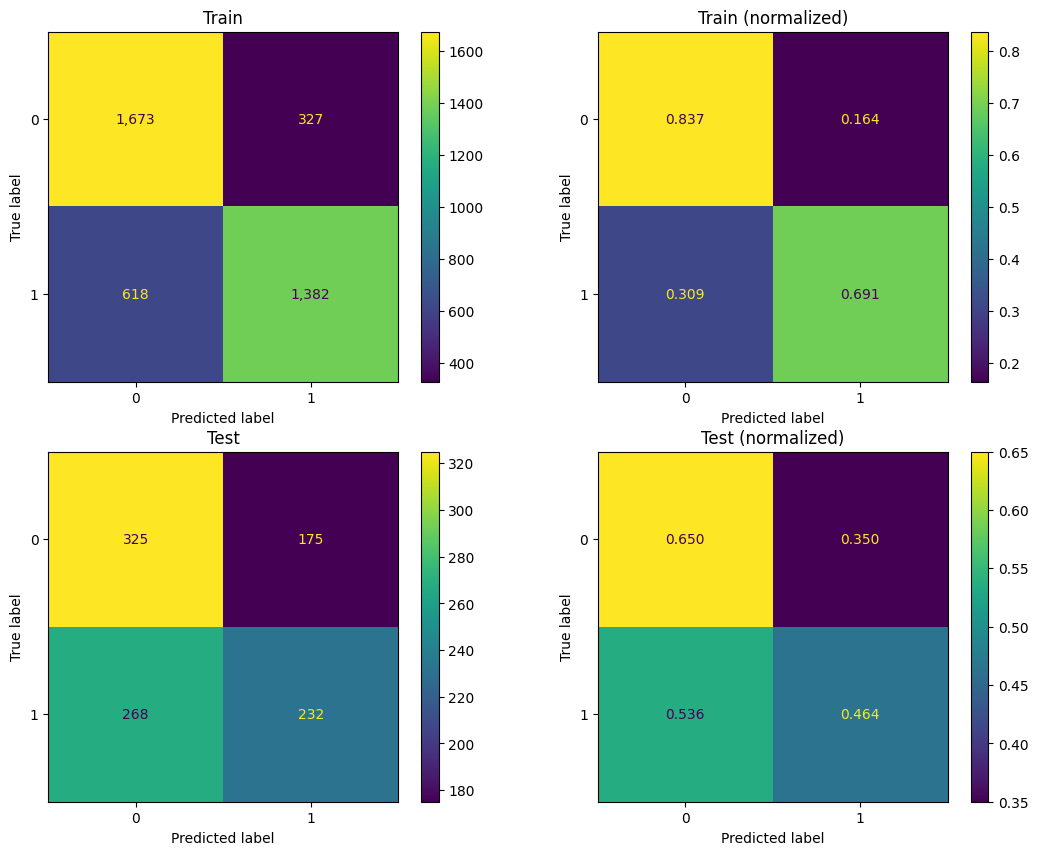

In [65]:
# Se empieza calculando la matriz de confusión

cm_train = confusion_matrix(y_train, preds_train, labels = knn_model.classes_)
cm_train_norm = confusion_matrix(y_train, preds_train, labels = knn_model.classes_, normalize = 'true')
cm_test = confusion_matrix(y_test, preds_test, labels = knn_model.classes_)
cm_test_norm = confusion_matrix(y_test, preds_test, labels = knn_model.classes_, normalize = 'true')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (13, 10))
ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = knn_model.classes_).plot(ax = ax1, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_train_norm, display_labels = knn_model.classes_).plot(ax = ax2, values_format = '.3f')
ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = knn_model.classes_).plot(ax = ax3, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_test_norm, display_labels = knn_model.classes_).plot(ax = ax4, values_format = '.3f')

ax1.set_title('Train')
ax2.set_title('Train (normalized)')
ax3.set_title('Test')
ax4.set_title('Test (normalized)')
plt.show()

In [66]:
# Se calculan las diferentes métricas de error para una comparacion más directa:
pd.DataFrame([
    {
        'Train': accuracy_score(y_train, preds_train),
        'Test': accuracy_score(y_test, preds_test)
    },
    {
        'Train': precision_score(y_train, preds_train),
        'Test': precision_score(y_test, preds_test)
    },
    {
        'Train': recall_score(y_train, preds_train),
        'Test': recall_score(y_test, preds_test)
    },
    {
        'Train': f1_score(y_train, preds_train),
        'Test': f1_score(y_test, preds_test)
    }
], index = ['Accuracy', 'Precision', 'Recall', 'F1'])

,Train,Test
Accuracy,0.763750,0.557000
Precision,0.808660,0.570025
Recall,0.691000,0.464000
F1,0.745214,0.511577


# Metodo 2: Decision Tree
Juan Felipe Patiño 201922857

In [67]:
bow_model = RandomForestClassifier(random_state = 2)

In [68]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<Axes: >

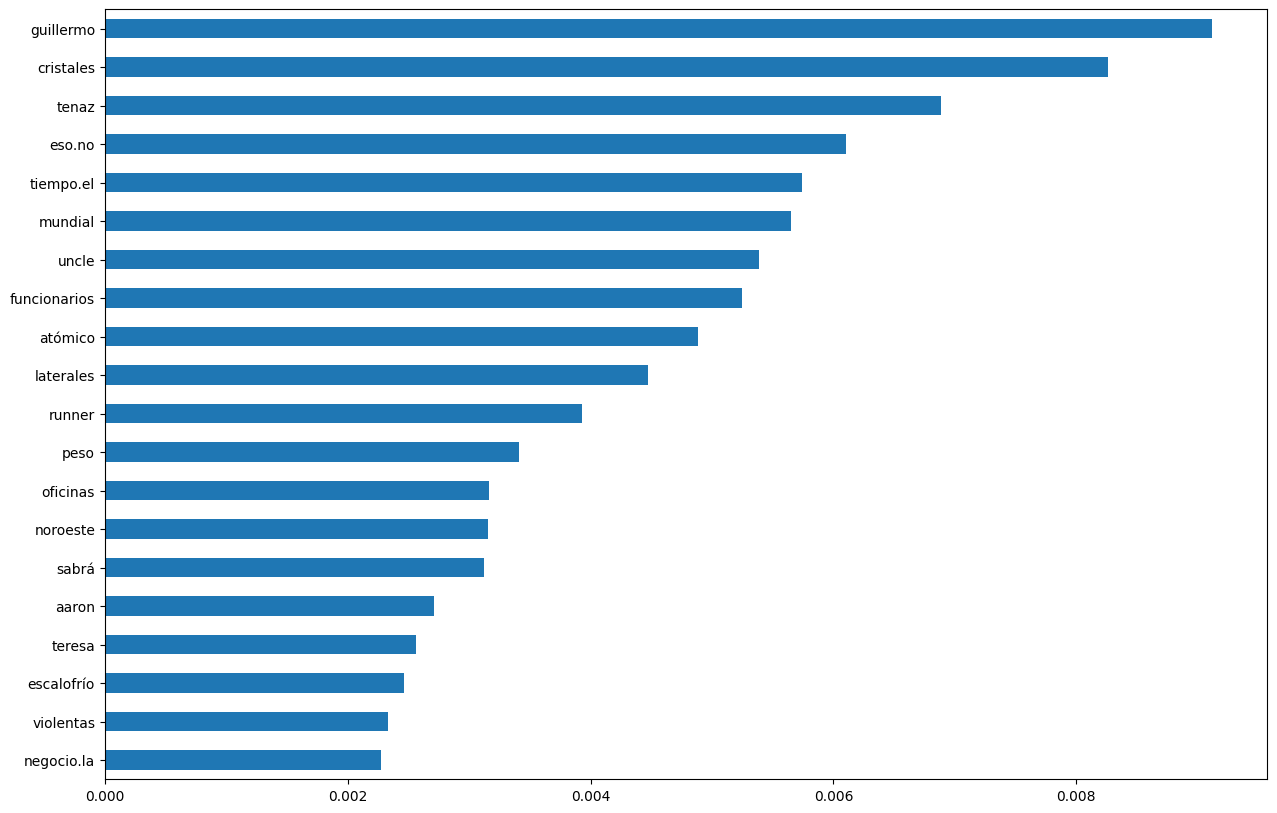

In [69]:
# La 'feature importance' en modelos basados en árboles de decisión indican cuales son las características más importantes al momento de tomar una decisión
pd.Series(bow_model.feature_importances_, index = bow.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [70]:
bow_estimators = bow_model.estimators_
print('Number of trees:', len(bow_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 152.33


In [71]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test))

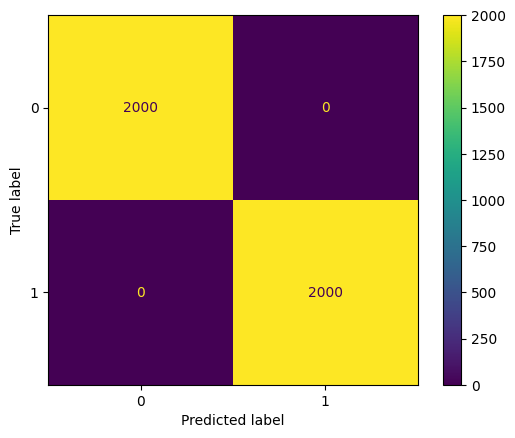

In [72]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

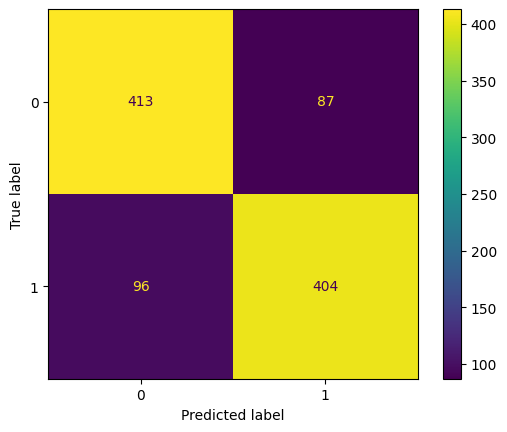

In [73]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [74]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_bow_predict, pos_label = 1))
    print('Recall:', recall_score(y_train, y_train_bow_predict, pos_label = 1))
    print('F1:', f1_score(y_train, y_train_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_bow_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_bow_predict, average = None))
    print('F1:', f1_score(y_train, y_train_bow_predict, average = None))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [75]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_bow_predict, pos_label = 1))
    print('Recall:', recall_score(y_test, y_test_bow_predict, pos_label = 1))
    print('F1:', f1_score(y_test, y_test_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
    print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: 0.8228105906313645
Recall: 0.808
F1: 0.8153380423814329


# Metodo 3: Random Forest

Juan Ricardo Diaz - 201922167

In [76]:
forest_model = RandomForestClassifier(random_state = 2)

In [111]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6], # Utilizamos alturas mucho más bajas ya gracias a que usamos "Bagging"
    'min_samples_split': [2, 3, 4, 5]
}

In [112]:
combinations = 1
for k, v in param_grid.items():
    combinations *= len(v)

print('Total de combinaciones a validar:', combinations)

Total de combinaciones a validar: 96


Como mencioné antes, vamos a tomar en cuenta únicamente el 50% de las combinaciones totales

In [113]:
# En este caso se decide buscar solo sobre el ~33% de las combinaciones
grid_forest_model = RandomizedSearchCV(forest_model, param_grid, n_iter = int(combinations / 2), scoring = ['precision', 'recall', 'f1'], refit = 'f1', cv = 10, n_jobs = -1, verbose = 1)

In [114]:
grid_forest_model.fit(X_bow, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=2),
                   n_iter=48, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [50, 100, 150, 200]},
                   refit='f1', scoring=['precision', 'recall', 'f1'],
                   verbose=1)

In [115]:
cv_results_df = pd.DataFrame(grid_forest_model.cv_results_)

In [116]:
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_depth,param_criterion,params,split0_test_precision,...,split3_test_f1,split4_test_f1,split5_test_f1,split6_test_f1,split7_test_f1,split8_test_f1,split9_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,1.032683,0.359334,0.102453,0.027305,150,4,4,entropy,"{'n_estimators': 150, 'min_samples_split': 4, 'max_depth': 4, 'criterion': 'entropy'}",0.725738,...,0.786885,0.769953,0.823256,0.779156,0.791774,0.770335,0.782407,0.789125,0.015475,18
1,0.341981,0.015711,0.032515,0.005886,50,3,6,gini,"{'n_estimators': 50, 'min_samples_split': 3, 'max_depth': 6, 'criterion': 'gini'}",0.748858,...,0.804938,0.725061,0.761194,0.758794,0.800983,0.766990,0.742317,0.767986,0.023397,34
2,0.514631,0.015674,0.053276,0.002973,100,3,4,gini,"{'n_estimators': 100, 'min_samples_split': 3, 'max_depth': 4, 'criterion': 'gini'}",0.708155,...,0.793503,0.771765,0.802784,0.765743,0.776942,0.759615,0.763033,0.777987,0.017303,32
3,0.331987,0.017606,0.030535,0.001091,50,4,6,entropy,"{'n_estimators': 50, 'min_samples_split': 4, 'max_depth': 6, 'criterion': 'entropy'}",0.715517,...,0.792271,0.736077,0.782609,0.777506,0.815725,0.763547,0.757647,0.775129,0.021558,33
4,0.578534,0.017898,0.058945,0.012694,100,2,5,entropy,"{'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 5, 'criterion': 'entropy'}",0.742489,...,0.796209,0.783019,0.807601,0.773399,0.788512,0.761446,0.781176,0.787063,0.013577,21


In [117]:
grid_forest_model.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'max_depth': 5,
 'criterion': 'entropy'}

In [118]:
grid_forest_model.best_score_

0.8028214180431146

In [119]:
best_forest_model_results_df = cv_results_df[[ c for c in cv_results_df.columns if 'split' in c][1:]].iloc[grid_forest_model.best_index_].reset_index()
best_forest_model_results_df['split'], best_forest_model_results_df['set'], best_forest_model_results_df['metric'] = zip(*list(best_forest_model_results_df['index'].apply(lambda x: x.split('_'))))
best_forest_model_results_df.rename(columns = {grid_forest_model.best_index_: 'value'}, inplace = True)
best_forest_model_results_df.drop(columns = 'index', inplace = True)

<Axes: xlabel='metric', ylabel='value'>

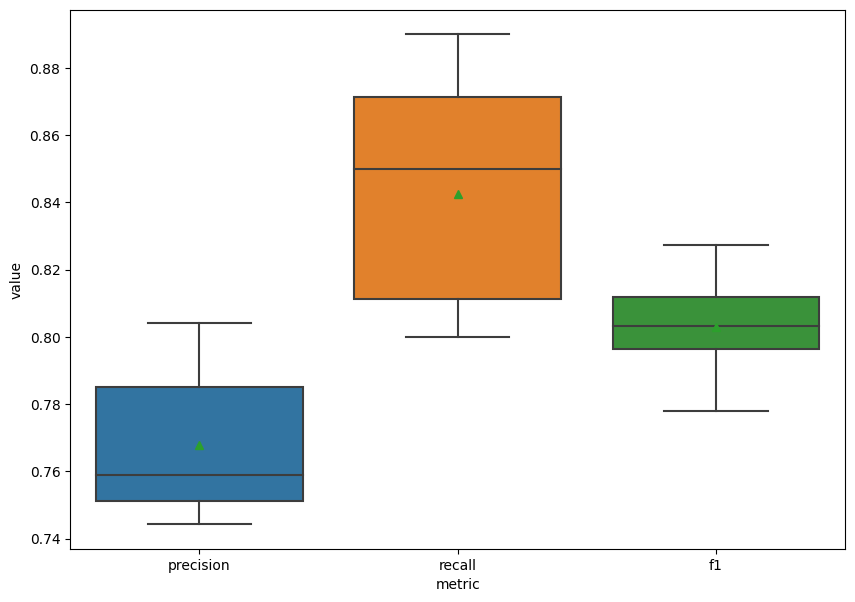

In [120]:
plt.figure(figsize = (10, 7))
sns.boxplot(x = 'metric', y = 'value', showmeans = True, data = best_forest_model_results_df)

In [123]:
preds_train = grid_forest_model.best_estimator_.predict(X_bow)
preds_test = grid_forest_model.best_estimator_.predict(bow.transform(X_test))

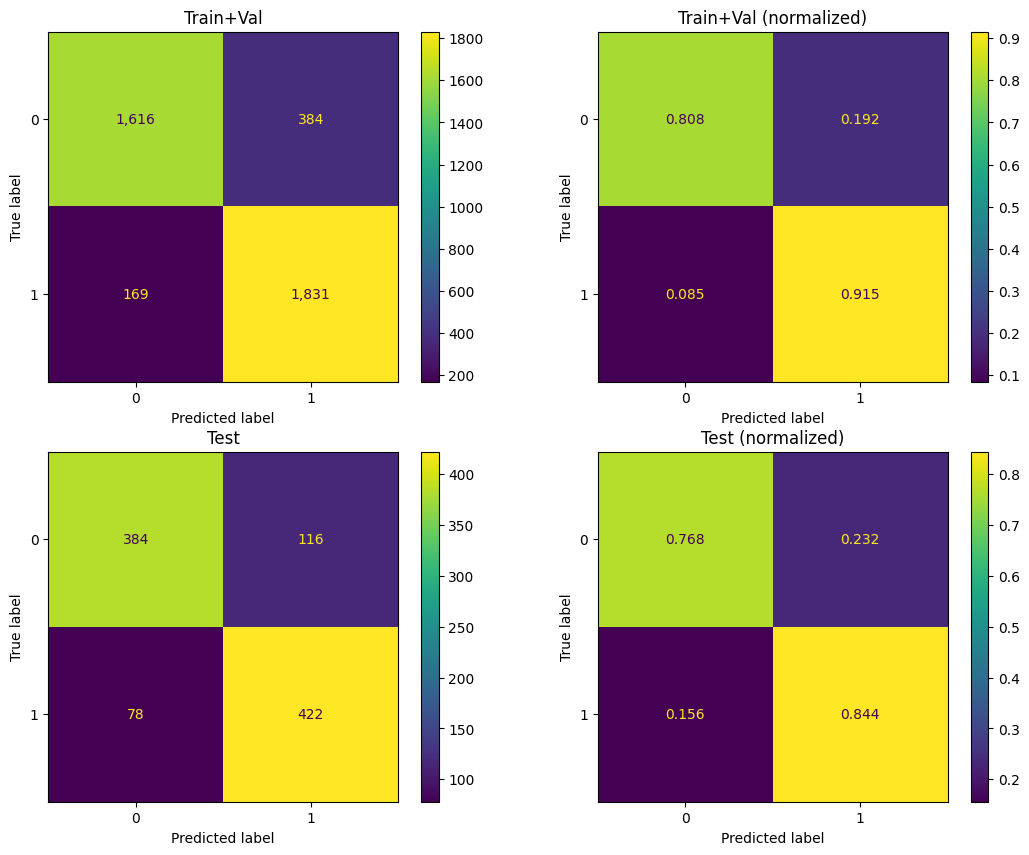

In [124]:
cm_train = confusion_matrix(y_train, preds_train, labels = grid_forest_model.best_estimator_.classes_)
cm_train_norm = confusion_matrix(y_train, preds_train, labels = grid_forest_model.best_estimator_.classes_, normalize = 'true')
cm_test = confusion_matrix(y_test, preds_test, labels = grid_forest_model.best_estimator_.classes_)
cm_test_norm = confusion_matrix(y_test, preds_test, labels = grid_forest_model.best_estimator_.classes_, normalize = 'true')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (13, 10))
ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = grid_forest_model.best_estimator_.classes_).plot(ax = ax1, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_train_norm, display_labels = grid_forest_model.best_estimator_.classes_).plot(ax = ax2, values_format = '.3f')
ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = grid_forest_model.best_estimator_.classes_).plot(ax = ax3, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_test_norm, display_labels = grid_forest_model.best_estimator_.classes_).plot(ax = ax4, values_format = '.3f')

ax1.set_title('Train+Val')
ax2.set_title('Train+Val (normalized)')
ax3.set_title('Test')
ax4.set_title('Test (normalized)')
plt.show()

In [125]:
pd.DataFrame([
    {
        'Train+Val': accuracy_score(y_train, preds_train),
        'Test': accuracy_score(y_test, preds_test)
    },
    {
        'Train+Val': precision_score(y_train, preds_train),
        'Test': precision_score(y_test, preds_test)
    },
    {
        'Train+Val': recall_score(y_train, preds_train),
        'Test': recall_score(y_test, preds_test)
    },
    {
        'Train+Val': f1_score(y_train, preds_train),
        'Test': f1_score(y_test, preds_test)
    }
], index = ['Accuracy', 'Precision', 'Recall', 'F1'])

,Train+Val,Test
Accuracy,0.861750,0.806000
Precision,0.826637,0.784387
Recall,0.915500,0.844000
F1,0.868802,0.813102
